In [1]:
import gym
import swingUp
import numpy as np
import numpy.random as rnd
import torch as pt
import matplotlib.pyplot as plt
%matplotlib inline

Here is code from the previous assignment for convenience. 

In [2]:
class nnQ(pt.nn.Module):
    """
    Here is a basic neural network with for representing a policy 
    """
    
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers):
        super().__init__()
        
        InputLayer = [pt.nn.Linear(stateDim+numActions,numHiddenUnits),
                      pt.nn.ReLU()] 
        
        HiddenLayers = []
        for _ in range(numLayers-1):
            HiddenLayers.append(pt.nn.Linear(numHiddenUnits,numHiddenUnits))
            HiddenLayers.append(pt.nn.ReLU())
            
        
        OutputLayer = [pt.nn.Linear(numHiddenUnits,1)]
        
        AllLayers = InputLayer + HiddenLayers + OutputLayer
        self.net = pt.nn.Sequential(*AllLayers)
        
        self.numActions = numActions
        
    def forward(self,x,a):
        x = pt.tensor(x,dtype=pt.float32)
        a = pt.tensor(a,dtype=pt.int64)
        b = pt.nn.functional.one_hot(a,self.numActions)
        
        c = b.float().detach()
        y = pt.cat([x,c])
        
        return self.net(y)
            
class sarsaAgent:
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers,
                epsilon=.1,gamma=.9,alpha=.1):
        self.Q = nnQ(stateDim,numActions,numHiddenUnits,numLayers)
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.numActions = numActions
        self.s_last = None
        
    def action(self,x):
        # This is an epsilon greedy selection
        if rnd.rand() < self.epsilon: # If less than epsilon, t
            a = rnd.randint(numActions)
        else:
            qBest = -np.inf
            for aTest in range(self.numActions):
                qTest = self.Q(x,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    a = aTest
        return a
    
    def update(self,s,a,r,s_next,done):
        
        # Compute the TD error, if there is enough data
        update = True
        if done:
            Q_cur = self.Q(s,a).detach().numpy()[0] 
            delta = r - Q_cur
            self.s_last = None
            Q_diff = self.Q(s,a)
        elif self.s_last is not None: # Not terminal state
            Q_next = self.Q(s,a).detach().numpy()[0]
            Q_cur = self.Q(self.s_last,self.a_last).detach().numpy()[0]
            delta = self.r_last + self.gamma * Q_next - Q_cur 
            Q_diff = self.Q(self.s_last,self.a_last)
        else:
            update = False
            
        # Update the parameter (weights) via the semi-gradient method
        if update:
            
            self.Q.zero_grad()
            Q_diff.backward()
            for p in self.Q.parameters():
                p.data.add_(self.alpha*delta,p.grad.data)
                
        
            
            
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)


The simulation is slightly modified from the previous homework. In particular, the episode lengths are restricted to be at most 500. 

[ 0.44873575  0.182895   -0.96365275 -0.26715795  0.29880664]
[ 0.45239365 -0.01490938 -0.96203898 -0.27291206 -0.0656599 ]
[ 0.45209546  0.17540884 -0.96239654 -0.27164848  0.12874428]
[ 0.45560364 -0.02239878 -0.96169389 -0.27412564 -0.23667443]
[ 0.45515566  0.16788118 -0.96298068 -0.26957041 -0.04278075]
[ 0.45851329 -0.02991246 -0.96321098 -0.26874637 -0.40774164]
[ 0.45791504  0.16044748 -0.96537051 -0.2608827  -0.2117179 ]
[ 0.46112399 -0.03731291 -0.96646652 -0.25679265 -0.57478549]
[ 0.46037773  0.15324752 -0.96935461 -0.24566571 -0.37402711]
[ 0.46344268  0.344078   -0.97116518 -0.23840761 -0.16877922]
[ 0.47032424  0.14645081 -0.97196441 -0.235128   -0.52676403]
[ 0.47325326  0.33745889 -0.97438757 -0.22487523 -0.31741207]
[ 0.48000244  0.13990338 -0.97579549 -0.21868509 -0.67226883]
[ 0.4828005   0.33119917 -0.9786475  -0.20554578 -0.45656391]
[ 0.48942449  0.13376089 -0.98048357 -0.19660103 -0.80682808]
[ 0.4920997   0.32545132 -0.98352825 -0.18075449 -0.5827048 ]
[ 0.4986

[-1.2924851   2.76295991 -0.62175318 -0.78321324  1.65069298]
[-1.2372259   2.9410237  -0.59556219 -0.80330921  1.58649588]
[-1.17840542  3.11891236 -0.56977775 -0.82179883  1.50923861]
[-1.11602718  3.29670687 -0.54471616 -0.83862048  1.41958479]
[-1.05009304  3.47448051 -0.52068997 -0.85374584  1.31828463]
[-0.98060343  3.65229622 -0.49800201 -0.86717588  1.20616364]
[-0.9075575   3.83020469 -0.47694002 -0.87893584  1.08411209]
[-0.83095341  4.00824301 -0.45777211 -0.88906957  0.95307536]
[-0.75078855  4.18643411 -0.44074297 -0.89763335  0.81404527]
[-0.66705987  4.36478675 -0.42607092 -0.90468976  0.66805258]
[-0.57976413  4.5432962  -0.41394564 -0.9103016   0.51616032]
[-0.48889821  4.35401049 -0.40452652 -0.91452627  0.13100065]
[-0.401818    4.53286609 -0.40212907 -0.91558299 -0.02934232]
[-0.31116068  4.71173542 -0.4026663  -0.91534685 -0.19063088]
[-0.21692597  4.89057488 -0.40615324 -0.91380498 -0.35172392]
[-0.11911447  4.70156827 -0.41257128 -0.91092532 -0.73553106]
[-0.0250

[ 0.00428863 -0.92653916 -0.97530694  0.22085373 -0.98816225]
[-0.01424215 -1.11767938 -0.97075197  0.24008458 -1.20286183]
[-0.03659574 -1.30831595 -0.96469586  0.26336647 -1.40986819]
[-0.06276206 -1.49831913 -0.95688712  0.29046005 -1.60738139]
[-0.09272844 -1.68755472 -0.94705671  0.32106632 -1.79360177]
[-0.12647954 -1.87588767 -0.93493261  0.35482534 -1.96675125]
[-0.16399729 -2.06318753 -0.92025595  0.39131699 -2.12510172]
[-0.20526104 -1.8634153  -0.90279813  0.43006457 -1.73429215]
[-0.24252935 -2.04919284 -0.88734094  0.46111393 -1.85943259]
[-0.2835132  -2.23401587 -0.86958316  0.49378651 -1.96986666]
[-0.32819352 -2.417831   -0.84945955  0.52765374 -2.06445724]
[-0.37655014 -2.60060728 -0.82695539  0.56226753 -2.14221862]
[-0.42856228 -2.78233958 -0.80211388  0.59717109 -2.20233873]
[-0.48420908 -2.96305075 -0.77504096  0.631911   -2.24419684]
[-0.54347009 -3.14279226 -0.74590727  0.66604981 -2.26737554]
[-0.60632594 -3.32164304 -0.71494711  0.69917854 -2.27166605]
[-0.6727

[-0.41437944 -4.3553139  -0.07779873  0.99696909 -7.97289193]
[-0.50148571 -4.47853337  0.08148995  0.99667416 -7.69416249]
[-0.59105638 -4.24405509  0.23329388  0.97240628 -7.42980173]
[-0.67593748 -4.3806128   0.3746875   0.92715116 -7.09612716]
[-0.76354974 -4.15887205  0.50206272  0.86483121 -6.94816995]
[-0.84672718 -3.94115872  0.61701636  0.78695033 -6.85786819]
[-0.92555036 -4.0999414   0.71881968  0.69519657 -6.47954753]
[-1.00754918 -3.89090286  0.8026315   0.59647522 -6.50055127]
[-1.08536724 -4.0637992   0.87318773  0.48738402 -6.11702948]
[-1.16664322 -3.86052171  0.9261395   0.37718116 -6.2399877 ]
[-1.24385366 -4.04441097  0.96588657  0.25896549 -5.87363578]
[-1.32474188 -3.84513781  0.98958116  0.14397617 -6.08621283]
[-1.40164463 -4.03680927  0.99974114  0.02275206 -5.75937214]
[-1.48238082 -3.84128465  0.99573107 -0.09230185 -6.04589404]
[-1.55920651 -4.03825732  0.97732681 -0.21173639 -5.77883307]
[-1.63997166 -3.84769121  0.94638919 -0.32302864 -6.12045163]
[-1.7169

[ 1.13662202 -0.09726652 -0.93863241  0.34491912  0.95553189]
[ 1.13467669 -0.28579697 -0.94505224  0.32691937  0.79149692]
[ 1.12896075 -0.08759432 -0.95010873  0.31191891  1.168579  ]
[ 1.12720886 -0.27670424 -0.95713862  0.28963021  0.99077068]
[ 1.12167478 -0.07854552 -0.96268949  0.27060849  1.36042001]
[ 1.12010387 -0.26842532 -0.96969508  0.24431832  1.16578597]
[ 1.11473536 -0.4589933  -0.97512746  0.22164483  0.96042632]
[ 1.10555549 -0.26128293 -0.97920478  0.20287433  1.31477912]
[ 1.10032984 -0.45263745 -0.98420035  0.1770584   1.09336128]
[ 1.09127709 -0.25526259 -0.98783651  0.15549605  1.43680105]
[ 1.08617183 -0.4475283  -0.99189641  0.12704927  1.19762626]
[ 1.07722127 -0.25065378 -0.99465474  0.10325668  1.52789744]
[ 1.07220819 -0.44391685 -0.9973452   0.07281859  1.26990985]
[ 1.06332986 -0.2477149  -0.9988728   0.04746706  1.58484012]
[ 1.05837556 -0.44200853 -0.99987537  0.01578744  1.30768351]
[ 1.04953539 -0.24663741 -0.99994628 -0.01036538  1.60534517]
[ 1.0446

[ 1.15829885  0.52262643 -0.98693634 -0.1611107  -1.48336636]
[ 1.16875138  0.71475724 -0.99128107 -0.13176433 -1.24630159]
[ 1.18304652  0.51781259 -0.99425716 -0.10701726 -1.57788156]
[ 1.19340277  0.71098675 -0.99713877 -0.07559278 -1.32124745]
[ 1.20762251  0.5147371  -0.99878796 -0.04922011 -1.63700392]
[ 1.21791725  0.70899091 -0.99986388 -0.01649918 -1.3604471 ]
[ 1.23209707  0.51360646 -0.99994266  0.01070881 -1.65833463]
[ 1.2423692   0.70890908 -0.99903762  0.04386163 -1.36224911]
[ 1.25654738  0.51452234 -0.99747199  0.07106075 -1.6406533 ]
[ 1.26683783  0.71077493 -0.99460375  0.10374673 -1.32612675]
[ 1.28105332  0.51746307 -0.99150264  0.13008657 -1.58402825]
[ 1.29140259  0.32474797 -0.98688459  0.1614274  -1.8323991 ]
[ 1.29789755  0.52230677 -0.98030727  0.19747824 -1.49248784]
[ 1.30834368  0.72006992 -0.97397677  0.22664786 -1.14362625]
[ 1.32274508  0.52912077 -0.96853845  0.24886394 -1.35596184]
[ 1.33332749  0.72724806 -0.96143415  0.27503524 -0.99495499]
[ 1.3478

[ 0.66239165 -0.18416487 -0.99125461  0.13196321  0.13210211]
[ 0.65870835  0.01258462 -0.99159981  0.12934382  0.46344255]
[ 0.65896004 -0.18043455 -0.99275606  0.1201474   0.21437298]
[ 0.65535135  0.0161957  -0.99326206  0.11588991  0.54250513]
[ 0.65567526 -0.17705223 -0.99446099  0.10510631  0.288658  ]
[ 0.65213422  0.01941848 -0.99505121  0.0993634   0.61263294]
[ 0.65252259 -0.17410932 -0.99619396  0.08716423  0.35299068]
[ 0.6490404   0.02215942 -0.99678449  0.08012917  0.67189957]
[ 0.64948359 -0.17169069 -0.99777123  0.06672756  0.40561736]
[ 0.64604978  0.02433295 -0.99827971  0.05863118  0.71861538]
[ 0.64653644 -0.16987121 -0.99901925  0.04427804  0.44504785]
[ 0.64313901  0.02586561 -0.99937378  0.03538417  0.75138287]
[ 0.64365633 -0.16871188 -0.99979266  0.0203625   0.47010235]
[ 0.64028209  0.0267005  -0.99993992  0.01096164  0.76914672]
[ 0.6408161  -0.16825621 -0.99999023 -0.00442106  0.47995194]
[ 0.63745097  0.02680106 -0.99990172 -0.01401966  0.7712352 ]
[ 0.6379

[ 0.81999871  0.71101947 -0.99982864  0.01851202 -0.17045881]
[ 0.8342191   0.51616838 -0.99975972  0.0219205  -0.45724284]
[ 0.84454247  0.32137204 -0.99951746  0.03106211 -0.74292251]
[ 0.85096991  0.51694217 -0.99894561  0.04590942 -0.44057661]
[ 0.86130875  0.32251661 -0.9985023   0.05470976 -0.71841007]
[ 0.86775908  0.1282482  -0.99761318  0.0690503  -0.99329159]
[ 0.87032405  0.32435612 -0.99604468  0.08885379 -0.67953103]
[ 0.87681117  0.13065535 -0.99474515  0.10238203 -0.94280995]
[ 0.87942428  0.32717595 -0.99263789  0.12111983 -0.61947776]
[ 0.8859678   0.13403092 -0.99106113  0.13340857 -0.87145315]
[ 0.88864841  0.33089152 -0.98858553  0.1506607  -0.5395797 ]
[ 0.89526624  0.13826831 -0.98690213  0.16132013 -0.78092222]
[ 0.89803161  0.33539414 -0.9842623   0.1767137  -0.44167826]
[ 0.90473949  0.14323934 -0.9826629   0.18540124 -0.67342052]
[ 0.90760428  0.34055985 -0.98007679  0.19861893 -0.32806323]
[ 0.91441548  0.148804   -0.97875251  0.20504515 -0.55157245]
[ 0.9173

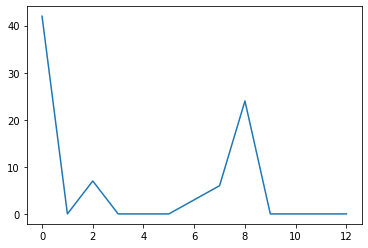

In [3]:
# This is the environment
env = swingUp.SwingUpEnv()

# For simplicity, we only consider forces of -1 and 1
numActions = 2
Actions = np.linspace(-1,1,numActions)

# This is our learning agent
gamma = .95

agent = sarsaAgent(5,numActions,20,2,epsilon=5e-2,gamma=gamma,alpha=1e-4)
maxSteps = 2e3

# This is a helper to deal with the fact that x[2] is actually an angle
x_to_y = lambda x : np.array([x[0],x[1],np.cos(x[2]),np.sin(x[2]),x[3]])

R = []
UpTime = []

step = 0
ep = 0
maxLen = 500
while step < maxSteps: # Outerloop is no of steps
    ep += 1
    x = env.reset() # Initialize
    C = 0.
    
    done = False
    t = 1
    while not done:  # These are the number of 
        t += 1
        step += 1
        y = x_to_y(x)
        
        # step #1
        a = agent.action(y)
        u = Actions[a:a+1]
        env.render()
        
        # step #2
        x_next,c,done,info = env.step(u)
        
        max_up_time = info['max_up_time']
        y_next = x_to_y(x_next)
    
        C += (1./t)*(c-C) # avg reward
        
         
        print(y)
        agent.update(y,a,c,y_next,done)
        x = np.copy(x_next)
        
        if done:
            break
            
        if step >= maxSteps:
            break
            
        if t > maxLen:
            agent.s_last = None
            break
            
        
        R.append(C)
    UpTime.append(max_up_time)
    #print('t:',ep+1,', R:',C,', L:',t-1,', G:',G,', Q:', Q_est, 'U:', max_up_time)
    print('Episode:',ep,'Total Steps:',step,', Ave. Reward:',C,', Episode Length:',t-1, 'Max Up-Time:', max_up_time)
env.close()

plt.plot(UpTime)

# Question 

Implement deep Q-learning as described in the paper here:

https://daiwk.github.io/assets/dqn.pdf

In this paper, we have the states, and so there is no need to do the pre-processing described there.

In my tests on this problem, it works substantially better than the SARSA  implementation 
with the following design choices:
* Use the same Q-network architecture as used  in the SARSA algorithm
* Same step size, discount factor, and learning rate as above
* Mini-batch size of 20
* Update the target network every 100 steps

The deep Q-learning method can be implemented via a modification of the SARSA code above.

You could probably make it work even better with further tuning.


In [ ]:
# Implement this code below and test it.

In [2]:
class DQN(pt.nn.Module):
    """
    Here is a basic neural network with for representing a policy 
    """
    
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers):
        super().__init__()
        
        InputLayer = [pt.nn.Linear(stateDim+numActions,numHiddenUnits),
                      pt.nn.ReLU()] 
        
        HiddenLayers = []
        for _ in range(numLayers-1):
            HiddenLayers.append(pt.nn.Linear(numHiddenUnits,numHiddenUnits))
            HiddenLayers.append(pt.nn.ReLU())
            
        
        OutputLayer = [pt.nn.Linear(numHiddenUnits,1)]
        
        AllLayers = InputLayer + HiddenLayers + OutputLayer
        self.net = pt.nn.Sequential(*AllLayers)
        
        self.numActions = numActions
        
    def forward(self,x,a):
        x = pt.tensor(x,dtype=pt.float32)
        a = pt.tensor(a,dtype=pt.int64)
        b = pt.nn.functional.one_hot(a,self.numActions)
        
        c = b.float().detach()
        y = pt.cat([x,c])
        
        return self.net(y)
            
class DQNAgent:
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers,
                epsilon=.1,gamma=.9,alpha=.1):
        self.Q = DQN(stateDim,numActions,numHiddenUnits,numLayers)
        self.Q_c = DQN(stateDim,numActions,numHiddenUnits,numLayers)
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.numActions = numActions
        self.s_last = None
        
    def action(self,x):
        # This is an epsilon greedy selection
        if rnd.rand() < self.epsilon: # If less than epsilon, t
            a = rnd.randint(numActions)
        else:
            qBest = -np.inf
            for aTest in range(self.numActions):
                qTest = self.Q(x,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    a = aTest
        return a
    
    def update(self,s,a,r,s_next,done):
        update = True
        if done:
            y = self.r_last 

        elif self.s_last is not None: # Not terminal state
            Q_next =[];
            Q_next.append(self.Q_c(s,1).detach().numpy()[0])
            Q_next.append(self.Q_c(s,-1).detach().numpy()[0])
            y = self.r_last + self.gamma * np.max(Q_next) 
        else:
            update = False
            return y
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)
            
    def gradUpdate(y,s_j_batch, a_batch):
        for i in range(100):
            loss +=  (y[i] - self.Q(s_j_batch[i],a_batch[i]))**2/100
        loss.zero_grad()
        loss.backward()
        for p in self.Q.parameters():
            p.data.add_(loss.grad.data)
    def reset():
        self.Q_c = self.Q
        


Episode: 1 Total Steps: 33 , Ave. Reward: -20.598001542448177 , Episode Length: 33 Max Up-Time: 0
Episode: 2 Total Steps: 66 , Ave. Reward: -23.083558340391917 , Episode Length: 33 Max Up-Time: 3
Episode: 3 Total Steps: 114 , Ave. Reward: -17.951280546926046 , Episode Length: 48 Max Up-Time: 8
Episode: 4 Total Steps: 147 , Ave. Reward: -19.193595308146442 , Episode Length: 33 Max Up-Time: 4
Episode: 5 Total Steps: 183 , Ave. Reward: -17.20272734368687 , Episode Length: 36 Max Up-Time: 0
Episode: 6 Total Steps: 217 , Ave. Reward: -18.90194071079208 , Episode Length: 34 Max Up-Time: 0
Episode: 7 Total Steps: 259 , Ave. Reward: -19.585033876419566 , Episode Length: 42 Max Up-Time: 0
Episode: 8 Total Steps: 294 , Ave. Reward: -16.913618905220538 , Episode Length: 35 Max Up-Time: 4
Episode: 9 Total Steps: 333 , Ave. Reward: -17.27130206453581 , Episode Length: 39 Max Up-Time: 10
Episode: 10 Total Steps: 370 , Ave. Reward: -15.979992053491298 , Episode Length: 37 Max Up-Time: 8
Episode: 11 T

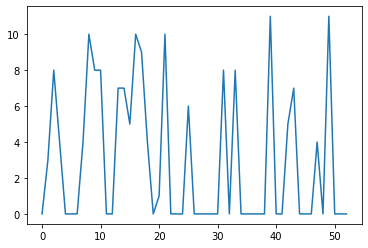

In [3]:
# This is the environment
env = swingUp.SwingUpEnv()

# For simplicity, we only consider forces of -1 and 1
numActions = 2
Actions = np.linspace(-1,1,numActions)

# This is our learning agent
gamma = .95
agent = DQNAgent(5,numActions,20,1,epsilon=5e-2,gamma=gamma,alpha=1e-4)
#agent_cap = DQNAgent(5,numActions,20,1,epsilon=5e-2,gamma=gamma,alpha=1e-4)

maxSteps = 2e3
minibatch_size = 20
# This is a helper to deal with the fact that x[2] is actually an angle
x_to_y = lambda x : np.array([x[0],x[1],np.cos(x[2]),np.sin(x[2]),x[3]]) # this is dyn of the cartpole

R = []
UpTime = []
D = []
step = 0
ep = 0
observe = 10000
while step < maxSteps:
    ep += 1
    x = env.reset() # initialize s
    C = 0.  # WHATS C
    
    done = False
    t = 1
    while not done:
        t += 1 
        step += 1
        y = x_to_y(x)
        
        # Step 1: Pick At via epsilon-greedy 
        a = agent.action(y)
        u = Actions[a:a+1]
        env.render()
        
        # Step 2: Observe S_t+1 and R_t+1
        x_next,c,done,info = env.step(u)
 
        max_up_time = info['max_up_time']
        y_next = x_to_y(x_next)

        C += (1./t)*(c-C)
        D.append((y, a, c, y_next,done))
        if t > observe:

            minibatch = random.sample(D, minibatch_size)
            # Step 4: Select a mini batch B in D
            minibatch_idx = np.random.randint(t, size=(minibatch_size,))
            # get the batch variables
            s_j_batch = [d[0] for d in minibatch]
            a_batch = [d[1] for d in minibatch]
            r_batch = [d[2] for d in minibatch]
            s_j1_batch = [d[3] for d in minibatch]
            term = [d[4] for d in minibatch]
            
            y_batch = []
            
            for i in range(0, len(minibatch)):
                y_batch.append(agent.update(s_j_batch,a_batch,r_batch[i],s_j1_batch[i],done[i]))
                
        
            # Compute gradient
            agent.gradUpdate(y_batch)
        
        
        if  t % 99 == 0:
            agent.reset
        
        x = x_next
        if done:
            break
            
        if step >= maxSteps:
            break
            
        
        R.append(C)
    UpTime.append(max_up_time)
    #print('t:',ep+1,', R:',C,', L:',t-1,', G:',G,', Q:', Q_est, 'U:', max_up_time)
    print('Episode:',ep,'Total Steps:',step,', Ave. Reward:',C,', Episode Length:',t-1, 'Max Up-Time:', max_up_time)
env.close()

plt.plot(UpTime)